# Get and explore dataset

In [204]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import re
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, BatchNormalization
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
# Assign text file to variable
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Helper function to load and preprocess data

# Function to perform preprocessing to remove strange characters
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

# Function to read text file
def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    # Loop through lines and extract title
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            # Call filter_words function
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                # Append the new line to data list
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
# Call load data function and pass in text file variable as an argument
# Assign to new variables
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
labels  = to_categorical(to_numeric_label(word_labels))

In [9]:
labels.shape

(1793, 2)

In [10]:
# Code to investigate data
column_values = ['Positive', 'Negative']

# Creating a dataframe from the data
df = pd.DataFrame(data = labels, 
                  index = data, 
                  columns = column_values)

df.head()

,Positive,Negative
one of the best crichton novels,1.0,0.0
the medicine of the future,1.0,0.0
beautiful,1.0,0.0
for lovers of robicheaux,1.0,0.0
a good book,1.0,0.0


In [11]:
# Mean review size and its standard deviation
df.describe()

,Positive,Negative
count,1793.000000,1793.000000
mean,0.486336,0.513664
std,0.499948,0.499948
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [194]:
# Boxplot - distribution of review length of dataset
word_labels

length_of_words = []
for i in data:
    num_words = i.split()
    length_of_words.append(len(num_words))

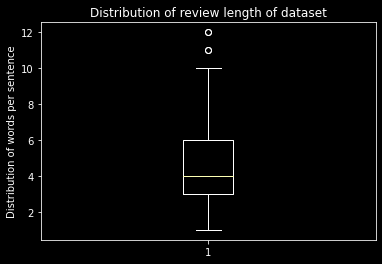

In [249]:
plt.boxplot(length_of_words)
plt.title('Distribution of review length of dataset')
plt.ylabel('Distribution of words per sentence')
plt.show()

In [22]:
# Tokenize the vocabulary 
tokenizer = Tokenizer(num_words=len(tokenizer.word_counts.keys())+1)

tokenizer.fit_on_texts(data) #create the vocabulary

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])
print(word_labels[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19, 492, 493], [2, 830, 4, 2, 831], [131], [6, 308, 4, 832], [1, 12, 3]]
['positive', 'positive', 'positive', 'positive', 'positive']


In [23]:
# Number of unique words
num_unique_words = len(tokenizer.word_counts.keys())+1
print(num_unique_words)

2560


In [26]:
# Code to split the data into a training and test set. 
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size = 0.25, 
                                                    random_state = 42,
                                                    shuffle=True, 
                                                    stratify=labels)

In [27]:
print('---review---')
print(X_train[10])
print('---label---')
print(y_train[10])

---review---
[36, 78, 84, 2484]
---label---
[0. 1.]


# Pre-processing

In [30]:
# Pre-processing - code to pre-process the data so that each review is the same length

# In order to feed this data into our RNN, all input documents must have the same length. 
# We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). 
# We can accomplish this using the pad_sequences() function in Keras. For now, set max_words to 4.

maxlen = 4

X_train = tf.keras.utils.pad_sequences(
    X_train, maxlen=maxlen, dtype='int32', padding='post', truncating='pre', value=0.0)

X_test = tf.keras.utils.pad_sequences(
    X_test, maxlen=maxlen, dtype='int32', padding='post', truncating='pre', value=0.0)

# Build and tune model

Define network architecture

In [205]:
vocabulary_size = len(tokenizer.word_counts.keys())+1
n_steps = 50
features = 1

model = Sequential()

model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=4))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 4, 100)            256000    
                                                                 
 batch_normalization (BatchN  (None, 4, 100)           400       
 ormalization)                                                   
                                                                 
 lstm_22 (LSTM)              (None, 32)                17024     
                                                                 
 dense_23 (Dense)            (None, 2)                 66        
                                                                 
Total params: 273,490
Trainable params: 273,290
Non-trainable params: 200
_________________________________________________________________


Train model

In [206]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

batch_size = 64
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
21/21 [==============================] - 20s 24ms/step - loss: 0.6804 - accuracy: 0.5580
Epoch 2/10
21/21 [==============================] - 0s 19ms/step - loss: 0.5230 - accuracy: 0.8586
Epoch 3/10
21/21 [==============================] - 0s 18ms/step - loss: 0.3276 - accuracy: 0.9323
Epoch 4/10
21/21 [==============================] - 0s 13ms/step - loss: 0.1710 - accuracy: 0.9673
Epoch 5/10
21/21 [==============================] - 1s 46ms/step - loss: 0.0944 - accuracy: 0.9807
Epoch 6/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0562 - accuracy: 0.9903
Epoch 7/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0382 - accuracy: 0.9933
Epoch 8/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0299 - accuracy: 0.9948
Epoch 9/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0241 - accuracy: 0.9940
Epoch 10/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0206 - accuracy: 0.9933


Examine performance of model

In [207]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.6904231905937195


Plot graphs for accuracy and loss

In [245]:
# Visualize Model Loss and Accuracy
def plot_graphs(history, metric='accuracy'):
  plt.plot(history.history[metric],color=color)
  plt.plot(history.history[metric],color=color)
  plt.xlabel("Epochs")
  plt.ylabel(metric)

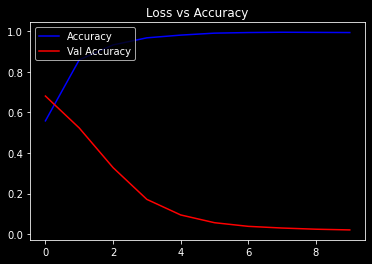

In [246]:
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['loss'], color='r')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper left')
plt.title('Loss vs Accuracy')
plt.show()

In [ ]:
# Instructions:
# - make a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test, before supplying them to the sklearn functions.

In [235]:
# helper to_class function to convert y_test,
converted_y_test = to_class(y_test)

In [236]:
# helper to_class function to convert y_pred
y_pred = model.predict(X_test)
y_pred = to_class(y_pred)

15/15 [==============================] - 4s 10ms/step


In [237]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(converted_y_test, y_pred)

print(cf_matrix)

[[138  80]
 [ 59 172]]


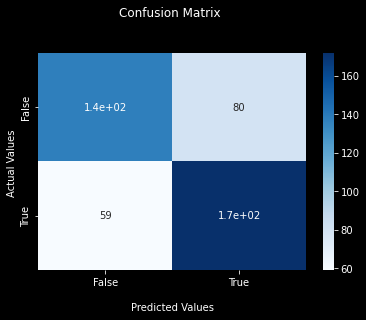

In [239]:
# Generate the confusion matrix
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [241]:
# Calculating precision and reall
precision = precision_score(converted_y_test, y_pred)
recall = recall_score(converted_y_test, y_pred)

F1 = 2 * (precision * recall) / (precision + recall)
 
print('Precision: ',precision)
print('Recall: ',recall)
print('F1_score: ',F1)

Precision:  0.6825396825396826
Recall:  0.7445887445887446
F1_score:  0.7122153209109732


# Make a prediction

In [251]:
# This is a very small set of completed new data to use to make predictions.
# Supply this data to each of your models and see how it does. 

prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = tf.keras.utils.pad_sequences(tokenized, padding='post', maxlen=maxlen)

# You can call the helper function "to_word_label" to map the output of the model 
# to the name of the class it was predicted to belong to.

predictions = model.predict(padded)
predictions = to_class(predictions)
predictions

1/1 [==============================] - 0s 69ms/step


array([1, 1, 0, 1, 1], dtype=int64)

In [252]:
# Actual reviews 1 = Positive, O = Negative
actual_review = np.array([1, 0, 1, 0, 0])
actual_review

array([1, 0, 1, 0, 0])

In [253]:
# Calculating precision and reall for new predictions
precision = precision_score(actual_review, predictions)
recall = recall_score(actual_review, predictions)

F1 = 2 * (precision * recall) / (precision + recall)
 
print('Precision: ',precision)
print('Recall: ',recall)
print('F1_score: ',F1)

Precision:  0.25
Recall:  0.5
F1_score:  0.3333333333333333
